# Introduction
This is an example of a Python notebook

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from os import listdir
from os.path import isfile, join

# Step 1 - Load and prepare Lockdown data


In [2]:
df_lockdown = pd.read_csv('dati_lockdown/EvoluzioneLockdown.csv')
times_lockdown = df_lockdown['Data']
column_list_lockdown = list(df_lockdown)
column_list_lockdown.remove("Data")
df_lockdown["sum"] = df_lockdown[column_list_lockdown].sum(axis=1)



# Step 2 - Plotting Lockdown


Text(0, 0.5, 'Lockdown status Overall')

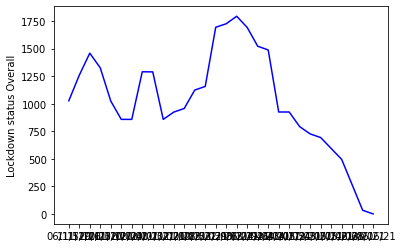

In [3]:

u_labels_lockdown = np.unique(column_list_lockdown)

cmap = plt.cm.get_cmap('hsv', u_labels_lockdown.size)

#for i in range(1, u_labels.size -1):
 #   plt.plot(times, df[column_list[i]], cmap(i), label=u_labels[i])

plt.ylabel('Lockdown status by Region')

plt.plot(times_lockdown, df_lockdown['sum'], 'b-', label='Sum')
plt.ylabel('Lockdown status Overall')




# Step 3 - Load spread data

In [4]:
mypath = 'dati_covid'
filelist = [f for f in listdir(mypath) if isfile(join(mypath, f))]
df2 = pd.DataFrame()
for ijk in filelist:
    frame = pd.read_csv(mypath + '/' + ijk)
    df2 = df2.append(frame)

In [5]:
# Step 4 - Prepare spread data

In [6]:
df3 = df2[["data","denominazione_regione","totale_positivi","tamponi"]].copy()
df3["average"] = df3['totale_positivi'].div(df3['tamponi']).round(4)
df_spread = df3[["data","denominazione_regione","average"]].copy()

times_spread = df_spread['data']
column_list_spread = list(df_spread)
column_list_spread.remove("data")

# Step 5 - Plotting spread

Text(0, 0.5, 'Spread status Overall')

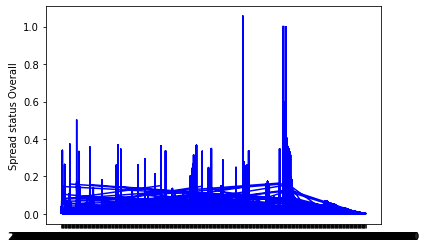

In [10]:
u_labels_spread = np.unique(column_list_spread)
cmap = plt.cm.get_cmap('hsv', u_labels_spread.size)

#for i in range(1, u_labels.size -1):
#plt.plot(times, df[column_list[i]], cmap(i), label=u_labels[i])
#plt.ylabel('Spread status by Region')

plt.plot(times_spread, df_spread['average'], 'b-', label='Average') 
plt.ylabel('Spread status Overall')
